# Case Study Using Pandas and PyCBA to Analyse a Business Problem

**Business Problem Statement:** How has allocated Branch POC mix changed from 1 Jan to 30 June, and what is the distribution of scores that were allocated?

Pre-Requisite - Requires active kerberos, ie kinit

Overall Flow:
* Import Packages
* Obtain Data Using PyCBA
    * Allocator historical data from OMNIA
    * Operational numbers from the Lab in GDW
* Clean, Join & Process Data Using Pandas
* Summarising Data into Insights Using Pandas

## Importing Packages

In [2]:
!pip install --user plotly
!pip install --user pycba
!pip install --user getpass

Looking in indexes: https://artifactory.ai.cba/artifactory/api/pypi/pypi/simple, https://artifactory.ai.cba/artifactory/api/pypi/python-zbi/simple
jupyterhub 0.9.2 has requirement tornado>=5.0, but you'll have tornado 4.4.2 which is incompatible.
distributed 1.21.8 has requirement tornado>=4.5.1, but you'll have tornado 4.4.2 which is incompatible.
Looking in indexes: https://artifactory.ai.cba/artifactory/api/pypi/pypi/simple, https://artifactory.ai.cba/artifactory/api/pypi/python-zbi/simple
jupyterhub 0.9.2 has requirement tornado>=5.0, but you'll have tornado 4.4.2 which is incompatible.
distributed 1.21.8 has requirement tornado>=4.5.1, but you'll have tornado 4.4.2 which is incompatible.
Looking in indexes: https://artifactory.ai.cba/artifactory/api/pypi/pypi/simple, https://artifactory.ai.cba/artifactory/api/pypi/python-zbi/simple
  Could not find a version that satisfies the requirement getpass (from versions: )
No matching distribution found for getpass


In [3]:
!pip install --user fbprophet

Looking in indexes: https://artifactory.ai.cba/artifactory/api/pypi/pypi/simple, https://artifactory.ai.cba/artifactory/api/pypi/python-zbi/simple
    100% |████████████████████████████████| 50.0MB 90.9MB/s 
  Running setup.py bdist_wheel for fbprophet ... error
  Complete output from command /opt/conda/bin/python -u -c "import setuptools, tokenize;__file__='/tmp/pip-install-r8ef5eaa/fbprophet/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d /tmp/pip-wheel-mi82c2oe --python-tag cp36:
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib
  creating build/lib/fbprophet
  creating build/lib/fbprophet/stan_model
  Traceback (most recent call last):
    File "<string>", line 1, in <module>
    File "/tmp/pip-install-r8ef5eaa/fbprophet/setup.py", line 123, in <module>
      """
    File "/opt/conda/lib/python3.6/site-packages/setuptools/__init__.py

In [1]:
import pandas as pd
import numpy as np
import getpass
from pycba.db import create_tera_conn, run_sql, get_data, create_hive_conn
import plotly.graph_objs as go
import plotly.offline as po
from plotly.tools import FigureFactory as FF
import matplotlib.pyplot as plt
import datetime as dt

## Obtain Data Using PyCBA

### Set Up Authentication (Requires kinit beforehand)

In [2]:
user = getpass.getuser()
print("The username detected is {0}".format(user))

The username detected is chonghsi


In [3]:
#conn_gdw = create_tera_conn(uid = user)
conn_hive = create_hive_conn(uid = user)

15:11:33 [pycba] INFO db::create_hive_conn: Hive connection to host nwr11omdhn03p.nw-omnia.cba successful


### Extract Allocator Historical Data From OMNIA

In [4]:
allocator_query = """
    select 
        A.cif,
        A.channel,
        A.propositionidentifier,
        A.experimentalgroup,
        A.nbcscore,
        A.allocated
    from 
        pr_cep_reporting.allocator A
    where
        A.channel = 'Branch'
        and A.allocated >= '2018-01-01' 
        and A.allocated < '2018-07-01'
"""

allocator_data = get_data(conn_hive, allocator_query)

15:15:02 [pycba] INFO db::get_data: Query successfully ran, returning a 1167215 x 6 DataFrame


In [5]:
allocator_data.to_csv("allocator_data.csv", index = False)

In [6]:
allocator_data = pd.read_csv("allocator_data.csv")

### Clean, Join & Process Data Using Pandas

#### Check head of the datasets

The **iloc** method in pandas subsets the dataframe by row numbers and/or column numbers, eg df.iloc[:20, :10] would output the top 20 rows and the top 10 columns

In [8]:
allocator_data.shape

(1167215, 6)

In [7]:
allocator_data.iloc[:10]

,cif,channel,propositionidentifier,experimentalgroup,nbcscore,allocated
0,735123001,Branch,/Service/Transactions/LargeDepositOFI30,T,394.412752,2018-06-05 07:00:00.0
1,299815101,Branch,/Sales/HomeLoan/HL2015,T,508.076499,2018-06-05 07:00:00.0
2,3006296,Branch,/Service/Transactions/LargeBalanceMovement,T,6734.710398,2018-06-05 07:00:00.0
3,459843325,Branch,/Sales/HomeLoan/HLPropertyApp,T,1023.994488,2018-06-05 07:00:00.0
4,8067598,Branch,/Service/Transactions/QNABranch,T,359437.167600,2018-06-05 07:00:00.0
5,272673758,Branch,/Sales/HomeLoan/HLOFI,T,37.728485,2018-06-05 07:00:00.0
6,98274957,Branch,/Service/Transactions/CardlessDepTech,E1,1.000000,2018-06-05 07:00:00.0
7,715888075,Branch,/Sales/HomeLoan/HLWinback,T,2462.954223,2018-06-05 07:00:00.0
8,633392708,Branch,/Sales/HomeLoan/HLOFI,T,102.907462,2018-06-05 07:00:00.0
9,10277037,Branch,/Sales/Transactions/Savings2015,E1,0.752616,2018-06-05 09:45:00.0


The datatypes contained in each column can be accessed using the **dtypes** attribute (note: object = not numeric)

In [7]:
allocator_data.dtypes

cif                        int64
channel                   object
propositionidentifier     object
experimentalgroup         object
nbcscore                 float64
allocated                 object
dtype: object

#### Split Out Identifier into Issue Group and NBC Name

In [8]:
allocator_data[["Issue", "Group", "NBC"]] = allocator_data["propositionidentifier"].str[1:].str.split("/", expand = True)

In [9]:
allocator_data.iloc[:10]

,cif,channel,propositionidentifier,experimentalgroup,nbcscore,allocated,Issue,Group,NBC
0,541494793,Branch,/Service/HomeLoan/HLEndDeal,T,1440.278220,2018-01-12 07:24:48.0,Service,HomeLoan,HLEndDeal
1,5837909,Branch,/Service/Customer/FHCMass2015,C,2.304539,2018-01-12 07:38:06.0,Service,Customer,FHCMass2015
2,920888785,Branch,/Service/Transactions/LargeWithdrawalCBA,T,1179.109545,2018-01-12 07:24:49.0,Service,Transactions,LargeWithdrawalCBA
3,219928255,Branch,/Service/HomeLoan/HLIntentToSell,T,25.185000,2018-01-12 07:25:11.0,Service,HomeLoan,HLIntentToSell
4,6878258,Branch,/Service/HomeLoan/HLTopUp,T,7.496910,2018-01-12 07:25:14.0,Service,HomeLoan,HLTopUp
5,6078120,Branch,/Service/Customer/FHCGoalTravel,T,59.319120,2018-01-12 07:25:08.0,Service,Customer,FHCGoalTravel
6,3841166,Branch,/Service/Customer/FHCMass2015,T,1.467749,2018-01-12 07:25:18.0,Service,Customer,FHCMass2015
7,9344797,Branch,/Service/Customer/FHCMass2015,E1,1.224089,2018-01-12 07:25:02.0,Service,Customer,FHCMass2015
8,1599711,Branch,/Service/Transactions/QNABranch,T,2437.167600,2018-01-12 07:24:46.0,Service,Transactions,QNABranch
9,639116000,Branch,/Service/Transactions/LargeBalanceMovement,T,3058.336207,2018-01-12 07:24:43.0,Service,Transactions,LargeBalanceMovement


#### Create Date Field from Allocated DateTime String

##### Convert DateTime String to DateTime Format

In [9]:
allocator_data["allocated_dt"] = pd.to_datetime(allocator_data["allocated"])

In [11]:
allocator_data.dtypes

cif                               int64
channel                          object
propositionidentifier            object
experimentalgroup                object
nbcscore                        float64
allocated                        object
Issue                            object
Group                            object
NBC                              object
allocated_dt             datetime64[ns]
dtype: object

##### Extract Date from DateTime

In [12]:
allocator_data["allocated_d"] = allocator_data["allocated_dt"].dt.date

In [13]:
allocator_data.dtypes

cif                               int64
channel                          object
propositionidentifier            object
experimentalgroup                object
nbcscore                        float64
allocated                        object
Issue                            object
Group                            object
NBC                              object
allocated_dt             datetime64[ns]
allocated_d                      object
dtype: object

##### Extract Month from DateTime

In [14]:
allocator_data["allocated_m"] = allocator_data["allocated_dt"].dt.to_period('M')

In [15]:
allocator_data.iloc[:10]

,cif,channel,propositionidentifier,experimentalgroup,nbcscore,allocated,Issue,Group,NBC,allocated_dt,allocated_d,allocated_m
0,541494793,Branch,/Service/HomeLoan/HLEndDeal,T,1440.278220,2018-01-12 07:24:48.0,Service,HomeLoan,HLEndDeal,2018-01-12 07:24:48,2018-01-12,2018-01
1,5837909,Branch,/Service/Customer/FHCMass2015,C,2.304539,2018-01-12 07:38:06.0,Service,Customer,FHCMass2015,2018-01-12 07:38:06,2018-01-12,2018-01
2,920888785,Branch,/Service/Transactions/LargeWithdrawalCBA,T,1179.109545,2018-01-12 07:24:49.0,Service,Transactions,LargeWithdrawalCBA,2018-01-12 07:24:49,2018-01-12,2018-01
3,219928255,Branch,/Service/HomeLoan/HLIntentToSell,T,25.185000,2018-01-12 07:25:11.0,Service,HomeLoan,HLIntentToSell,2018-01-12 07:25:11,2018-01-12,2018-01
4,6878258,Branch,/Service/HomeLoan/HLTopUp,T,7.496910,2018-01-12 07:25:14.0,Service,HomeLoan,HLTopUp,2018-01-12 07:25:14,2018-01-12,2018-01
5,6078120,Branch,/Service/Customer/FHCGoalTravel,T,59.319120,2018-01-12 07:25:08.0,Service,Customer,FHCGoalTravel,2018-01-12 07:25:08,2018-01-12,2018-01
6,3841166,Branch,/Service/Customer/FHCMass2015,T,1.467749,2018-01-12 07:25:18.0,Service,Customer,FHCMass2015,2018-01-12 07:25:18,2018-01-12,2018-01
7,9344797,Branch,/Service/Customer/FHCMass2015,E1,1.224089,2018-01-12 07:25:02.0,Service,Customer,FHCMass2015,2018-01-12 07:25:02,2018-01-12,2018-01
8,1599711,Branch,/Service/Transactions/QNABranch,T,2437.167600,2018-01-12 07:24:46.0,Service,Transactions,QNABranch,2018-01-12 07:24:46,2018-01-12,2018-01
9,639116000,Branch,/Service/Transactions/LargeBalanceMovement,T,3058.336207,2018-01-12 07:24:43.0,Service,Transactions,LargeBalanceMovement,2018-01-12 07:24:43,2018-01-12,2018-01


#### Summarising Allocation Numbers & Charting

In [16]:
allocator_data.groupby(["allocated_m"])["propositionidentifier"].count()

allocated_m
2018-01    169416
2018-02    180639
2018-03    190091
2018-04    186993
2018-05    244457
2018-06    195619
Freq: M, Name: propositionidentifier, dtype: int64

2018-01


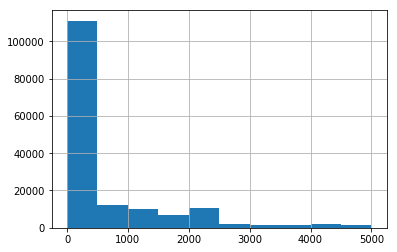

2018-02


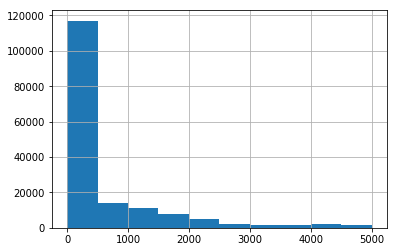

2018-03


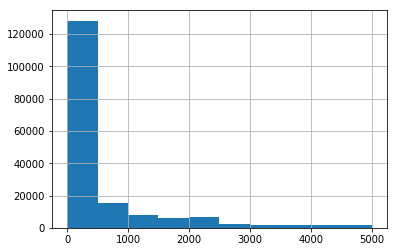

2018-04


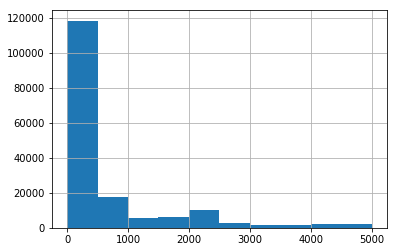

2018-05


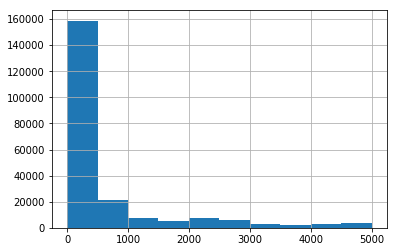

2018-06


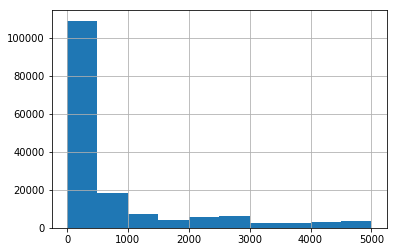

In [17]:
for i, j in allocator_data.groupby(["allocated_m"])["nbcscore"]:
    print(i)
    j.hist(range = [0, 5000])
    plt.show()

### [Advanced] Introduction to Plotly

Plotly is an interactive graphing package available in both Python and R.

In Python, a plot / subplot is the basic building block and contains 2 elements: data (**what**) and layout (**how**).

##### First Plot

In [30]:
import plotly.graph_objs as go # Used to build a plot from data & layout
from plotly.tools import FigureFactory as FF # Optional - used for widgets to make plots more interactive
import plotly.offline as po # Used to render the chart

In [45]:
groups = allocator_data["Group"].drop_duplicates().sort_values().tolist()
months = allocator_data["allocated_m"].drop_duplicates().sort_values().tolist()

In [73]:
data = [
        go.Histogram(x=allocator_data.loc[
                        (allocator_data["Group"] == group) 
                        & (allocator_data["allocated_m"] == pd.Period(year = 2018, month = 1, freq = 'M'))]["nbcscore"],
                     opacity = 0.6,
                     name = group,
                     xbins = dict(start = 0,
                                 end = 1000,
                                 size = 10)
                    )
        for group in groups
       ]

In [74]:
layout = go.Layout(
    width=1000,
    height=500,
    title='Histogram of Leads in Jan-2018',
    xaxis=dict(
        title='NBC Score',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='# Allocated Leads',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    barmode='overlay'
)

In [75]:
fig = dict(data=data, layout=layout)
po.plot(fig, filename='first_plot.html')

'file:///home/lamk5/181115_Python_Training/first_plot.html'

##### Plot with Drop Downs

In [82]:
data = [
        go.Histogram(x=allocator_data.loc[
                        (allocator_data["Group"] == group) 
                        & (allocator_data["allocated_m"] == perd)]["nbcscore"],
                     opacity = 0.5,
                     name = group,
                     xbins = dict(start = 0,
                                 end = 1000,
                                 size = 10)
                    )
        for perd in months
        for group in groups
       ]

In [83]:
updatemenus=list([
    dict(
        buttons=[   
            dict(
                label=months[i].strftime('%Y-%m'),
                method='update',
                args=[{'visible': i * len(groups) * [False] + len(groups) * [True] + (len(months) - i - 1) * len(groups) * [False]},
                      {'title': 'Distribution of Leads for {0}'.format(months[i].strftime('%b %Y'))}]
            )
            for i in range(len(months))
        ],
        direction = 'down',
        pad = {'r': 10, 't': 10},
        showactive = True,
        x = 0.1,
        xanchor = 'right',
        y = 1.1,
        yanchor = 'top' 
    ),
])

In [84]:
layout = go.Layout(
    width=1000,
    height=500,
    title='Histogram of Leads in Jan 2018',
    xaxis=dict(
        title='NBC Score',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='# Allocated Leads',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    barmode='overlay',
    updatemenus=updatemenus
)

In [85]:
fig = dict(data=data, layout=layout)
po.plot(fig, filename='second_plot.html')

'file:///home/lamk5/181115_Python_Training/second_plot.html'

### Time Series Modelling with FBProphet

In [2]:
from fbprophet import Prophet

#### Prepare data such that it has day level allocated volumes by business group

In [45]:
df = allocator_data.groupby(["Group", "allocated_d"])["nbcscore"].count().reset_index()
df.columns = ["Group", "ds", "y"] # Columns DS and Y are required by FBProphet

In [46]:
df.iloc[:10]

,Group,ds,y
0,Customer,2018-01-02,171
1,Customer,2018-01-03,184
2,Customer,2018-01-04,160
3,Customer,2018-01-05,163
4,Customer,2018-01-08,1079
5,Customer,2018-01-09,2434
6,Customer,2018-01-10,2601
7,Customer,2018-01-11,2708
8,Customer,2018-01-12,2301
9,Customer,2018-01-15,1916


In [57]:
train = df.loc[(df["ds"] <= dt.date(2018, 4, 30))
       & (df["Group"] == "Customer"), ["ds", "y"]]
test = df.loc[(df["ds"] > dt.date(2018, 4, 30))
       & (df["Group"] == "Customer"), ["ds", "y"]]

#### Auto-Time Series with Facebook Prophet

In [58]:
m = Prophet()
m.fit(train)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [59]:
future = m.make_future_dataframe(periods=61)
future.iloc[-5:]

,ds
135,2018-06-26
136,2018-06-27
137,2018-06-28
138,2018-06-29
139,2018-06-30


In [60]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].iloc[-5:]

,ds,yhat,yhat_lower,yhat_upper
135,2018-06-26,2990.525215,2097.935909,3853.113610
136,2018-06-27,2882.709412,1990.608736,3777.227283
137,2018-06-28,2914.311146,2051.603926,3769.267918
138,2018-06-29,2633.358573,1757.693450,3543.089168
139,2018-06-30,1621.693969,761.667880,2507.779664


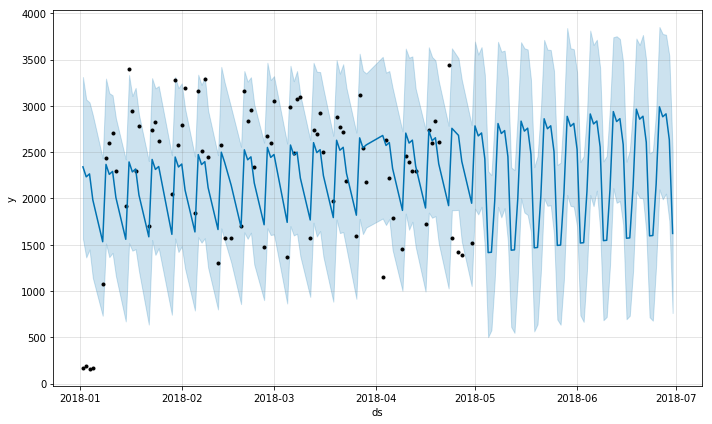

In [61]:
fig1 = m.plot(forecast)

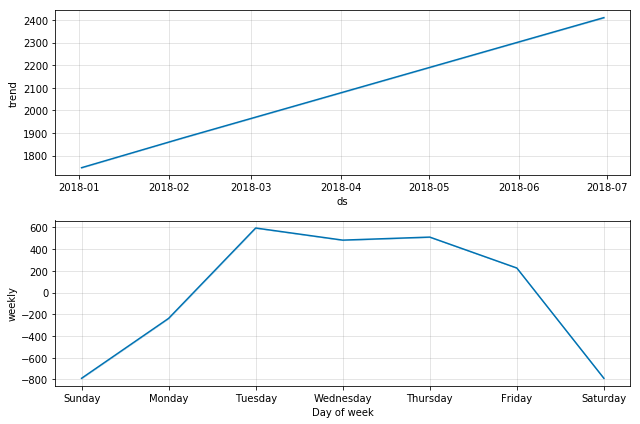

In [62]:
fig2 = m.plot_components(forecast)